Steane code encoding fault tolerance
=============================== 

1. Set up two logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerance as per scheme B, C and D from Goto H. Minimizing resource overheads for fault-tolerant preparation of encoded states of the Steane code. Sci Rep. 2016 Jan 27;6:19578. 

3. Compare this with the non fault tolerant encoding circuit and a single qubit.

3. Find out if either scheme have a tolerance.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise, 
    mean_of_list,
    calculate_standard_error,
    print_time,
    process_FT_results,
    get_parity_check_matrix,
    get_codewords
    )

import matplotlib.pyplot as plt

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

NOISE = True                              #Test with noise
SHOTS = 100000                            #Number of shots to run 
SHOTS_SINGLE = 1000000                    #Number of shots to run 

MEASURE_NOISE = 0.0046                    #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366       #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022
FACTOR_LIST = [1, 0.1, 0.01, 0.001, 0.0001]
ITERATIONS = 25
SIMULATOR = Aer.get_backend('qasm_simulator')
TITLE = 'Steane code encoding with fault tolerance'

#constants needed for correction and detection with FTc scheme
ANC_ZERO = '0000'
ANC_ONE = '0001'
QUBIT_LIST = [2,4,5] 

ANCILLA_TYPES = 2
ANCILLA_QUBITS = 3
ANCILLA_MEASUREMENT_REPEATS = 3

DATA_MEASUREMENT_REPEATS = 3
DATA_MEAS_QUBITS = 1
DATA_MEAS_START = ANCILLA_TYPES * ANCILLA_QUBITS * ANCILLA_MEASUREMENT_REPEATS
DATA_START = DATA_MEAS_START + (DATA_MEAS_QUBITS * DATA_MEASUREMENT_REPEATS)

The parity check matrix is specified, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The codewords are used to find if output strings are valid.  

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
def single_qubit():
    cd = QuantumRegister(1,'data')
    sd = ClassicalRegister(1,'measure_data') 
    qc = QuantumCircuit(cd, sd)
    qc.measure(cd, sd)
    if NOISE:
        result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS_SINGLE).result()
    else:
        result = execute(qc, SIMULATOR, shots = SHOTS_SINGLE).result()
    counts = result.get_counts(qc)
    return(counts)

Function module for non fault tolerant decoding circuit.

In [6]:
def encoding():
    # no fault tolerance
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False)
    qubit.set_up_logical_zero(0)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme b from Goto's paper.  See worksheet 
"Steane_code_encoding_FTb" for circuit diagram

In [7]:
def encoding_FTb():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, 
                                   ancilla = False, fault_tolerant_b = True, 
                                   data_rounds = 3
                                  )
    qubit.set_up_logical_zero(0)
    for i in range(3):
        qubit.barrier()
        qubit.set_up_logical_zero(1)
        qubit.barrier()
        qubit.logical_gate_CX(0, 1)
        qubit.barrier()
        qubit.logical_measure_data_FT(logical_qubit = 1, measure_round = i + 1)
        qubit.barrier() 
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme c from Goto's paper.  See worksheet 
"Steane_code_encoding_FTc" for circuit diagram

In [8]:
def encoding_FTc():
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False, 
                                   fault_tolerant_c = True, data_rounds = 3,                )
    qubit.set_up_logical_zero(0)
    qubit.barrier()
    qubit.barrier()
    for i in range(3):
        qubit.encode_fault_tolerant_method_C(QUBIT_LIST)
        qubit.barrier()
        qubit.logical_measure_data_FT(0, i + 1)
        qubit.barrier()
    qubit.logical_measure_data(0)
    qubit.barrier() 
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, based on own design.  See worksheet 
"Steane_code_encoding_FTd" for circuit diagram.

In [9]:
def encoding_FTd():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, 
                                   ancilla = False, fault_tolerant_b = True, 
                                   data_rounds = 3
                                  )
    qubit.set_up_logical_zero(0)
    for i in range(3):
        qubit.barrier()
        qubit.logical_data_reset(1)
        qubit.barrier()
        qubit.logical_gate_CX(0, 1)
        qubit.barrier()
        qubit.logical_measure_data_FT(logical_qubit = 1, measure_round = i + 1)
        qubit.barrier() 
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme c from Goto's paper, with FT ancilla.  See worksheet 
"Steane_code_encoding_FTc" for circuit diagram

In [10]:
def encoding_and_detection_FTc():
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, 
                           fault_tolerant_ancilla = True, fault_tolerant_c = True, 
                           ancilla_rounds = 3, data_rounds = 3
                          )
    qubit.set_up_logical_zero(0)
    for i in range(ANCILLA_MEASUREMENT_REPEATS):
        qubit.encode_fault_tolerant_method_C(QUBIT_LIST)
        qubit.barrier()
        qubit.logical_measure_data_FT(0, i + 1)
        qubit.barrier()
    for i in range(ANCILLA_MEASUREMENT_REPEATS):
        qubit.set_up_ancilla(0)
        qubit.logical_measure_ancilla(0, i)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    return(counts)
    #print ('The different states can be counted.  The simulated result are', counts)

Function module for non FT circuit with ancilla

In [11]:
def encoding_with_ancilla():
    # no fault tolerance
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
    qubit.set_up_logical_zero(0)
    qubit.set_up_ancilla(0)
    qubit.logical_measure_data(0)
    qubit.logical_measure_ancilla(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

Calculation and processing of results

In [12]:
single = []

nonft = []
ftb = []
ftc = []
ftd = []
ftca = []
nonfta = []

nonft_ps = []
ftb_ps = []
ftc_ps = []
ftd_ps = []
ftca_ps = []
nonfta_ps = []

error_single = []
error_nonft = []
error_ftb = []
error_ftc = []
error_ftd = []
error_ftca = []
error_nonfta = []

error_nonft_ps = []
error_ftb_ps = []
error_ftc_ps = []
error_ftd_ps = []
error_ftca_ps = []
error_nonfta_ps = []

for factor in FACTOR_LIST:
    print()
    print_time()
    print(f'Processing factor {factor}')
    if NOISE:
        noise_model = get_noise(MEASURE_NOISE * factor, SINGLE_GATE_DEPOLARISING * factor, 
                                TWO_GATE_DEPOLARISING * factor, SINGLE_GATE_ERRORS, TWO_GATE_ERRORS
                               )
               
    print('Processing single qubit')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = single_qubit()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, '0')
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'The standard devation is {standard_deviation:.8f}')
    single.append(mean)
    error_single.append(standard_error)
    print()
    
    print('process non FT circuit')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding()
        error_rate, rej, acc, val, inval = process_FT_results(counts, codewords, verbose = False)
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps = process_FT_results(counts, codewords, 
                                                                                 verbose = False, 
                                                                                 post_selection = True
                                                                                )
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.6f}')
    nonft.append(mean)
    error_nonft.append(standard_error_ps)
    nonft_ps.append(mean_ps)
    error_nonft_ps.append(standard_error_ps)
    print()
    
    print('Processing FTb')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTb()
        error_rate, rej, acc, val, inval  = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 3, data_meas_qubits = 1,
                                                                            data_meas_repeats = 3, 
                                                                            data_meas_strings = codewords,
                                                                            post_selection = False
                                                                           )
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps  = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 3, data_meas_qubits = 1,
                                                                            data_meas_repeats = 3, 
                                                                            data_meas_strings = codewords,
                                                                            post_selection = True
                                                                           )
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.8f}')
    ftb.append(mean)
    error_ftb.append(standard_error)
    ftb_ps.append(mean_ps)
    error_ftb_ps.append(standard_error_ps)
    print()
    
    print('Processing FTc')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTc()
        error_rate, rej, acc, val, inval  = process_FT_results(counts, codewords, verbose = False,
                                                                data_start = 3, data_meas_qubits = 1,
                                                                data_meas_repeats = 3, 
                                                                data_meas_strings = ['0'],
                                                                post_selection = False
                                                                )
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps  = process_FT_results(counts, codewords, verbose = False,
                                                                            data_start = 3, data_meas_qubits = 1,
                                                                            data_meas_repeats = 3, 
                                                                            data_meas_strings = ['0'],
                                                                            post_selection = True 
                                                                           )
        
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.8f}')
    ftc.append(mean)
    error_ftc.append(standard_error)
    ftc_ps.append(mean_ps)
    error_ftc_ps.append(standard_error_ps)
    print()
    
    print('Processing FTd')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding_FTd()
        error_rate, rej, acc, val, inval = process_FT_results(counts, codewords, verbose = False,
                                                                data_start = 3, data_meas_qubits = 1,
                                                                data_meas_repeats = 3, 
                                                                data_meas_strings = codewords,
                                                                post_selection = False   
                                                                )
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps = process_FT_results(counts, codewords, verbose = False,
                                                                data_start = 3, data_meas_qubits = 1,
                                                                data_meas_repeats = 3, 
                                                                data_meas_strings = codewords,
                                                                post_selection = True            
                                                                )
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.8f}')
    ftd.append(mean)
    error_ftd.append(standard_error)
    ftd_ps.append(mean_ps)
    error_ftd_ps.append(standard_error_ps)
    print()
    
    print('process FTc with FT ancilla')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding_and_detection_FTc()
        error_rate, rej, acc, val, inval = process_FT_results(counts, codewords, 
                                                              anc_zero = ANC_ZERO,
                                                              anc_one = ANC_ONE,
                                                              verbose = False,  
                                                              data_meas_start = DATA_MEAS_START, 
                                                              data_start = DATA_START,
                                                              ancilla_qubits = ANCILLA_QUBITS, 
                                                              ancilla_meas_repeats = ANCILLA_MEASUREMENT_REPEATS,
                                                              data_meas_qubits = DATA_MEAS_QUBITS, 
                                                              data_meas_repeats = DATA_MEASUREMENT_REPEATS,
                                                              post_selection = False
                                                             )
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps = process_FT_results(counts, codewords, 
                                                                             anc_zero = ANC_ZERO,
                                                                             anc_one = ANC_ONE,
                                                                             verbose = False,  
                                                                             data_meas_start = DATA_MEAS_START, 
                                                                             data_start = DATA_START,
                                                                             ancilla_qubits = ANCILLA_QUBITS, 
                                                                             ancilla_meas_repeats = ANCILLA_MEASUREMENT_REPEATS,
                                                                             data_meas_qubits = DATA_MEAS_QUBITS, 
                                                                             data_meas_repeats = DATA_MEASUREMENT_REPEATS,
                                                                             post_selection = True
                                                                            )  
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.8f}')
    ftca.append(mean)
    error_ftca.append(standard_error)
    ftca_ps.append(mean_ps)
    error_ftca_ps.append(standard_error_ps)
    print()
    
    print('process non FT circuit with ancilla')
    results_list = []
    results_list_ps = []
    for iteration in range(ITERATIONS):
        counts = encoding_with_ancilla()
        error_rate, rej, acc, val, inval = process_FT_results(counts, codewords, verbose = False,
                                                              data_start = 2, 
                                                              ancilla_qubits = 1,
                                                              post_selection = False
                                                             )
        error_rate_ps, rej_ps, acc_ps, val_ps, inval_ps = process_FT_results(counts, codewords, verbose = False,
                                                                             data_start = 2, 
                                                                             ancilla_qubits = 1,
                                                                             post_selection = True
                                                                            )
        results_list.append(error_rate)
        results_list_ps.append(error_rate_ps)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    mean_ps = mean_of_list(results_list_ps)
    standard_deviation_ps, standard_error_ps = calculate_standard_error(results_list_ps)
    print(f'Without post selection')
    print(f'  The mean is {mean:.8f}, the standard error is {standard_error:.8f}')
    print(f'  The standard devations {standard_deviation:.8f}')
    print(f'With post selection')
    print(f'  The mean is {mean_ps:.8f}, the standard error is {standard_error_ps:.8f}')
    print(f'  The standard devations {standard_deviation_ps:.8f}')
    nonfta.append(mean)
    error_nonfta.append(standard_error)
    nonfta_ps.append(mean_ps)
    error_nonfta_ps.append(standard_error_ps)
    print()


Current Time = 18:57:02
Processing factor 1
Processing single qubit
The mean is 0.00459516, the standard error is 0.00001569
The standard devation is 0.00007844

process non FT circuit
Without post selection
  The mean is 0.18699440, the standard error is 0.00022669
  The standard devations 0.00113344
With post selection
  The mean is 0.00049640, the standard error is 0.00000814
  The standard devations 0.000041

Processing FTb
Without post selection
  The mean is 0.10617018, the standard error is 0.00033766
  The standard devations 0.00168831
With post selection
  The mean is 0.00002204, the standard error is 0.00000554
  The standard devations 0.00002772

Processing FTc
Without post selection
  The mean is 0.12866847, the standard error is 0.00022644
  The standard devations 0.00113219
With post selection
  The mean is 0.00024569, the standard error is 0.00000846
  The standard devations 0.00004230

Processing FTd
Without post selection
  The mean is 0.10443823, the standard error i

Without post selection
  The mean is 0.00004000, the standard error is 0.00000408
  The standard devations 0.00002041
With post selection
  The mean is 0.00000880, the standard error is 0.00000167
  The standard devations 0.00000833



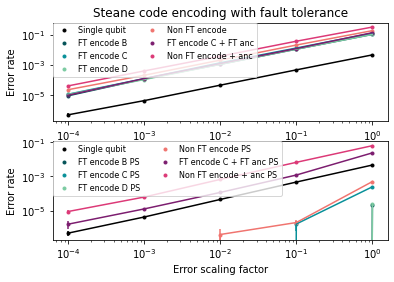

In [13]:
color1 = 'black'
color2 = '#045257'
color3 = '#089099'
color4 = '#7CCBA2'
color5 = '#F0746F'
color6 = '#7C1D6F'
color7 = '#DC3977'
#plt.xlabel('Error scaling factor')
#plt.ylabel('Error rate')

plt.subplot(2, 1, 1)
plt.title(TITLE)
plt.plot(FACTOR_LIST, single, '.', color = color1, linestyle = '', label = 'Single qubit' )
plt.plot(FACTOR_LIST, ftb, '.', color = color2, linestyle = '', label = 'FT encode B' )
plt.plot(FACTOR_LIST, ftc, '.', color = color3, linestyle = '', label = 'FT encode C' )
plt.plot(FACTOR_LIST, ftd, '.', color = color4, linestyle = '', label = 'FT encode D' )
plt.plot(FACTOR_LIST, nonft, '.', color = color5, linestyle = '', label = 'Non FT encode' )
plt.plot(FACTOR_LIST, ftca, '.', color = color6, linestyle = '', label = 'FT encode C + FT anc' )
plt.plot(FACTOR_LIST, nonfta, '.', color = color7, linestyle = '', label = 'Non FT encode + anc' )

plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = color1 )   
plt.errorbar(FACTOR_LIST, ftb, yerr = error_ftb, color = color2 )
plt.errorbar(FACTOR_LIST, ftc, yerr = error_ftc, color = color3 )
plt.errorbar(FACTOR_LIST, ftd, yerr = error_ftd, color = color4 )
plt.errorbar(FACTOR_LIST, nonft, yerr = error_nonft, color = color5 )
plt.errorbar(FACTOR_LIST, ftca, yerr = error_ftca, color = color6 )
plt.errorbar(FACTOR_LIST, nonfta, yerr = error_nonfta, color = color7 )

plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 1), ncol = 2, loc = 2, borderaxespad = 0., prop={"size":8})

plt.subplot(2, 1, 2)
plt.plot(FACTOR_LIST, single, '.', color = color1, linestyle = '', label = 'Single qubit' )
plt.plot(FACTOR_LIST, ftb_ps, '.', color = color2, linestyle = '', label = 'FT encode B PS' )
plt.plot(FACTOR_LIST, ftc_ps, '.', color = color3, linestyle = '', label = 'FT encode C PS' )
plt.plot(FACTOR_LIST, ftd_ps, '.', color = color4, linestyle = '', label = 'FT encode D PS' )
plt.plot(FACTOR_LIST, nonft_ps, '.', color = color5, linestyle = '', label = 'Non FT encode PS' )
plt.plot(FACTOR_LIST, ftca_ps, '.', color = color6, linestyle = '', label = 'FT encode C + FT anc PS' )
plt.plot(FACTOR_LIST, nonfta_ps, '.', color = color7, linestyle = '', label = 'Non FT encode + anc PS' )

plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = color1 )   
plt.errorbar(FACTOR_LIST, ftb_ps, yerr = error_ftb_ps, color = color2 )
plt.errorbar(FACTOR_LIST, ftc_ps, yerr = error_ftc_ps, color = color3 )
plt.errorbar(FACTOR_LIST, ftd_ps, yerr = error_ftd_ps, color = color4 )
plt.errorbar(FACTOR_LIST, nonft_ps, yerr = error_nonft_ps, color = color5 )
plt.errorbar(FACTOR_LIST, ftca_ps, yerr = error_ftca_ps, color = color6 )
plt.errorbar(FACTOR_LIST, nonfta_ps, yerr = error_nonfta_ps, color = color7 )

plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.legend(bbox_to_anchor=(0, 1), ncol = 2, loc = 2, borderaxespad = 0., prop={"size":8})

fname = TITLE + '.png'
plt.savefig(fname)

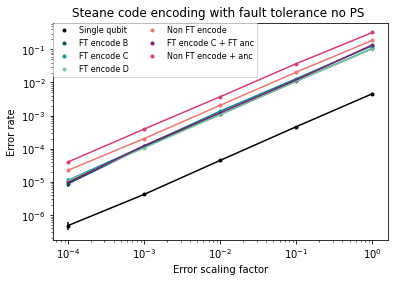

In [14]:
title = TITLE + ' no PS '
plt.title(title)
plt.plot(FACTOR_LIST, single, '.', color = color1, linestyle = '', label = 'Single qubit' )
plt.plot(FACTOR_LIST, ftb, '.', color = color2, linestyle = '', label = 'FT encode B' )
plt.plot(FACTOR_LIST, ftc, '.', color = color3, linestyle = '', label = 'FT encode C' )
plt.plot(FACTOR_LIST, ftd, '.', color = color4, linestyle = '', label = 'FT encode D' )
plt.plot(FACTOR_LIST, nonft, '.', color = color5, linestyle = '', label = 'Non FT encode' )
plt.plot(FACTOR_LIST, ftca, '.', color = color6, linestyle = '', label = 'FT encode C + FT anc' )
plt.plot(FACTOR_LIST, nonfta, '.', color = color7, linestyle = '', label = 'Non FT encode + anc' )

plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = color1 )   
plt.errorbar(FACTOR_LIST, ftb, yerr = error_ftb, color = color2 )
plt.errorbar(FACTOR_LIST, ftc, yerr = error_ftc, color = color3 )
plt.errorbar(FACTOR_LIST, ftd, yerr = error_ftd, color = color4 )
plt.errorbar(FACTOR_LIST, nonft, yerr = error_nonft, color = color5 )
plt.errorbar(FACTOR_LIST, ftca, yerr = error_ftca, color = color6 )
plt.errorbar(FACTOR_LIST, nonfta, yerr = error_nonfta, color = color7 )

plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 1), ncol = 2, loc = 2, borderaxespad = 0., prop={"size":8})

fname = title + '.png'
plt.savefig(fname)

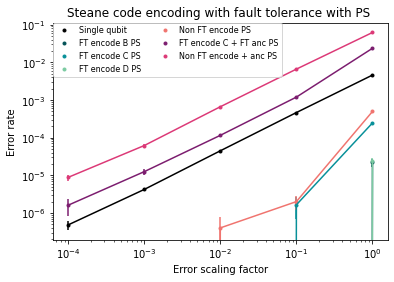

In [15]:
title = TITLE + ' with PS '
plt.title(title)
plt.plot(FACTOR_LIST, single, '.', color = color1, linestyle = '', label = 'Single qubit' )
plt.plot(FACTOR_LIST, ftb_ps, '.', color = color2, linestyle = '', label = 'FT encode B PS' )
plt.plot(FACTOR_LIST, ftc_ps, '.', color = color3, linestyle = '', label = 'FT encode C PS' )
plt.plot(FACTOR_LIST, ftd_ps, '.', color = color4, linestyle = '', label = 'FT encode D PS' )
plt.plot(FACTOR_LIST, nonft_ps, '.', color = color5, linestyle = '', label = 'Non FT encode PS' )
plt.plot(FACTOR_LIST, ftca_ps, '.', color = color6, linestyle = '', label = 'FT encode C + FT anc PS' )
plt.plot(FACTOR_LIST, nonfta_ps, '.', color = color7, linestyle = '', label = 'Non FT encode + anc PS' )

plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = color1 )   
plt.errorbar(FACTOR_LIST, ftb_ps, yerr = error_ftb_ps, color = color2 )
plt.errorbar(FACTOR_LIST, ftc_ps, yerr = error_ftc_ps, color = color3 )
plt.errorbar(FACTOR_LIST, ftd_ps, yerr = error_ftd_ps, color = color4 )
plt.errorbar(FACTOR_LIST, nonft_ps, yerr = error_nonft_ps, color = color5 )
plt.errorbar(FACTOR_LIST, ftca_ps, yerr = error_ftca_ps, color = color6 )
plt.errorbar(FACTOR_LIST, nonfta_ps, yerr = error_nonfta_ps, color = color7 )

plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.legend(bbox_to_anchor=(0, 1), ncol = 2, loc = 2, borderaxespad = 0., prop={"size":8})

fname = title + '.png'
plt.savefig(fname)